# Homework 3
#### Yufeng Yuan
#### yy208@duke.edu

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
import os
import skimage.filters as filters
from time import gmtime, strftime, sleep
from scipy import interpolate as interp
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [3]:
def move_focus(sid=1, step=0):
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    #return pop.stdout


def take_photos(sid=1, step=100, iters=1, start=-1500):
    subprocess.run('rm dbGrab*', \
               stdout=subprocess.PIPE, shell=True)
    subprocess.run('rsh ubuntu@10.0.1.4 "rm dbGrab*"', \
               stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    for i in range(iters):
        subprocess.run('rsh ubuntu@10.0.1.4 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                --file-name dbGrab_'+str(i*step)+' --image-res 8"', stdout=subprocess.PIPE, shell=True)
        cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp ubuntu@10.0.1.4:dbGrab* .', \
                stdout=subprocess.PIPE, shell=True)
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    return pop

def read_eval(x=0, y=0, h=2160, w=3840):
    names = os.listdir()
    pics = []
    scores = []
    for name in sorted(names):
        if name[:6] == 'dbGrab':
            pic = imio.imread(name)
            pics.append(pic)
            scores.append(np.sum(filters.sobel(pic[x:x+w, y:y+h,0])))
    ind = scores.index(max(scores))
    #imio.imshow(pics[ind])
    focus = 100 * ind
    return focus, pics[ind], scores

def auto_focus(sid=1, region=[0,0,2160,3840]):
    take_photos(sid, 100, 10)
    x, y, h, w = region
    focus, pics, scores = read_eval(x, y, h, w)
    start = -1500
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(focus+100)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    pop = take_photos(sid, 0, 1, 0)
    imio.imshow(pop)
    return focus, pop, scores

def grabImage(sid=1, imres=8, fm=1, cameraNumber=6):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        pop=pop[28672:]
        pop=np.reshape(pop,(2160,3840))
        pop=np.append(pop[:,2060:] ,pop[:,:2060],axis=1)
    return pop


def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI



#### Task 1
How convolutional neural network works in image processing--reference: Stanford CS231n course material http://cs231n.github.io/

#### Task 2
License plate tracking from videos taken by multi-camera system

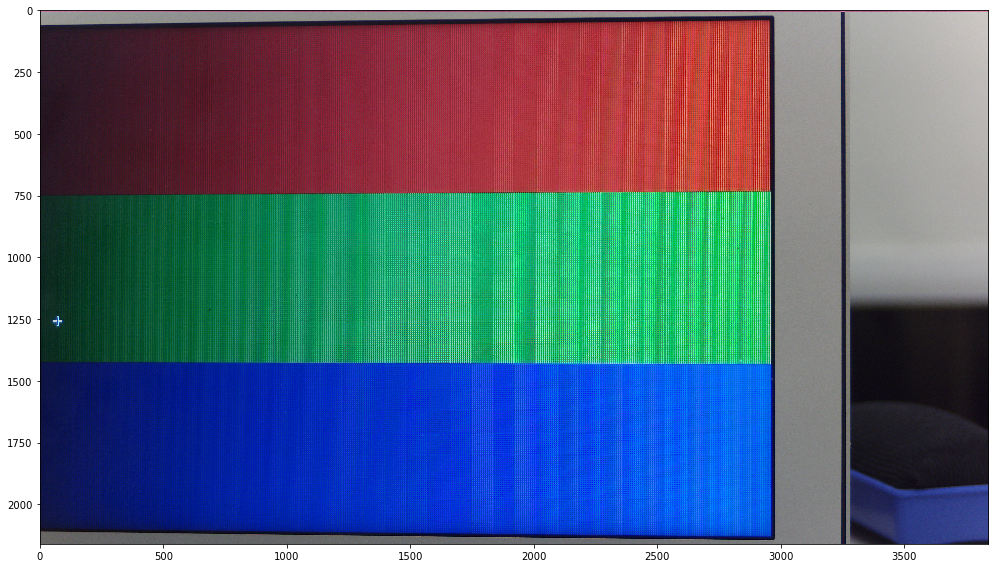

In [4]:
auto_focus()
a = grabImage(fm=1, cameraNumber=4)
imio.imshow(a)


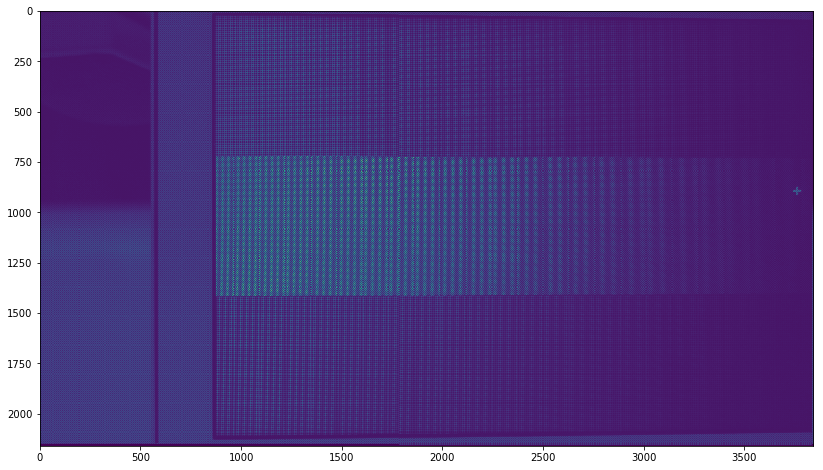

In [5]:
# Task 3
b = grabImage(fm=2, cameraNumber=4)
plt.imshow(b)

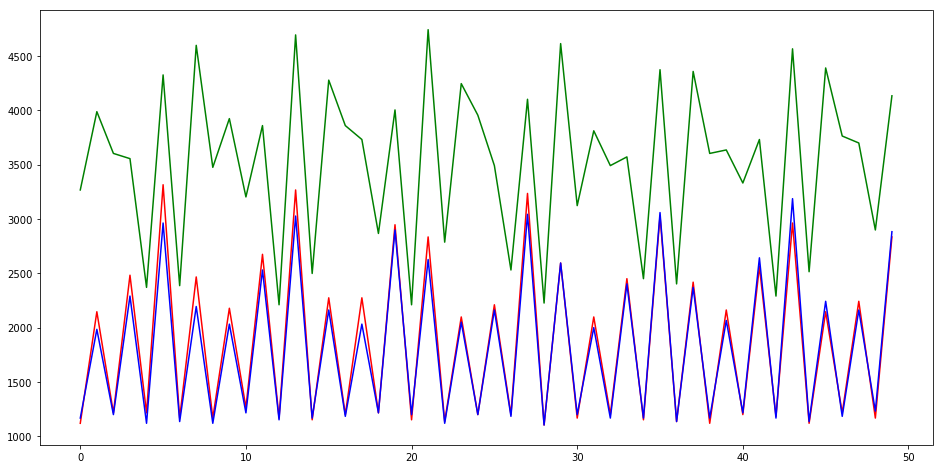

In [7]:
rg=np.arange(50)
plt.plot(rg,b[500,1000+rg],'r',rg,b[501,1000+rg],'g',rg,b[502,1000+rg],'b')

In the area selected here, the original color is blue and the blue sensor would response most strongly in this area. According to the diagram above, we know that row 501 is gbgbgb and the rest two are grgrgr. To know the specific distribution of color sensors, we need to know another row.

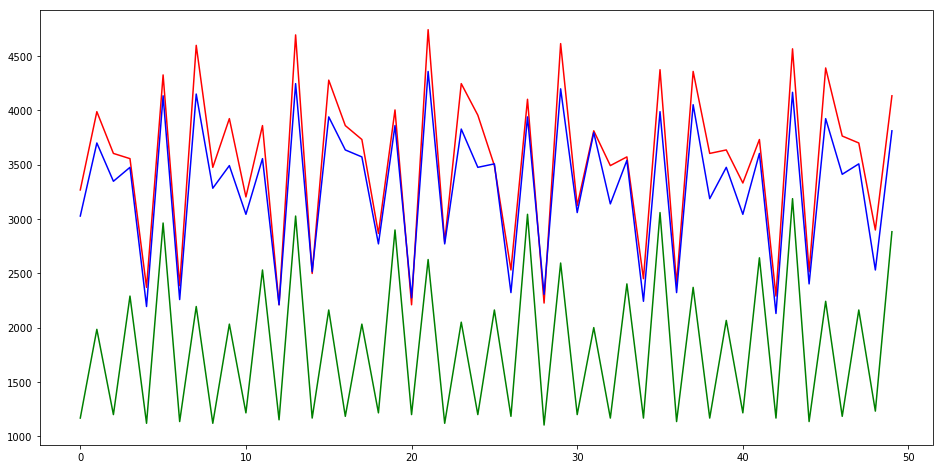

In [9]:
plt.plot(rg,b[501,1000+rg],'r',rg,b[502,1000+rg],'g',rg,b[503,1000+rg],'b')

From the diagram, we can know that (501, 1000), (503, 1000) are green, so (502, 1000) must be red. Further, we can know that (501, 1001), (503, 1001) are blue.
even columns even rows are red
odd columns, odd rows are blue
odd column even row green
even column odd row green

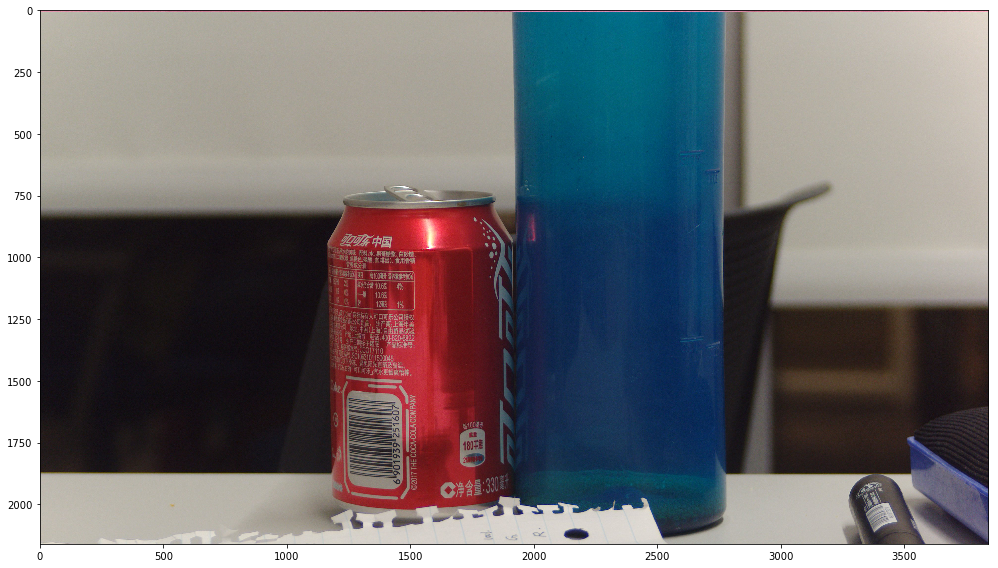

In [4]:
#auto_focus()
a = grabImage(fm=1, cameraNumber=4)
imio.imshow(a)

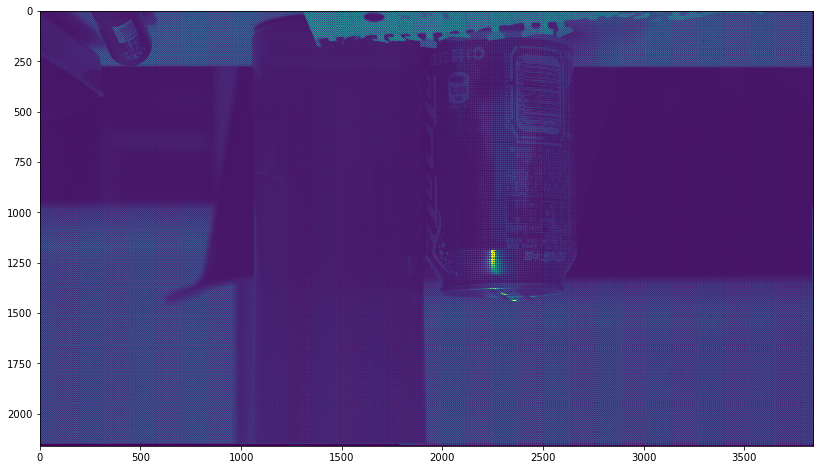

In [5]:
b = grabImage(fm=2, cameraNumber=4)
#c = demosaic1(b)
plt.imshow(b)

In [9]:
# Task 4
def demosaic(raw):
    # weird here, for the 1780 boundary, there are differnt color sensor for these two regions
    raw_left, raw_right = raw[:, :1780], raw[:, 1780:]
    red_left = raw_left[::2, ::2]
    green_left = raw_left[1::2, 0::2]
    blue_left = raw_left[1::2, 1::2]
    red_right = raw_right[1::2, 0::2]
    green_right = raw_right[1::2, 1::2]
    blue_right = raw_right[0::2, 1::2]
    
    red = np.append(red_left, red_right, axis=1)
    green = np.append(green_left, green_right, axis=1)
    blue = np.append(blue_left, blue_right, axis=1)
    jpg_image = np.dstack((red, green, blue))
    jpg_image = 800 * np.log(jpg_image) / np.max(np.log(jpg_image)) - 550
    jpg_image = jpg_image.astype(np.uint8)
    jpg_image = np.repeat(np.repeat(jpg_image, 2, axis=1), 2, axis=0)
    return jpg_image

c = demosaic(b)

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


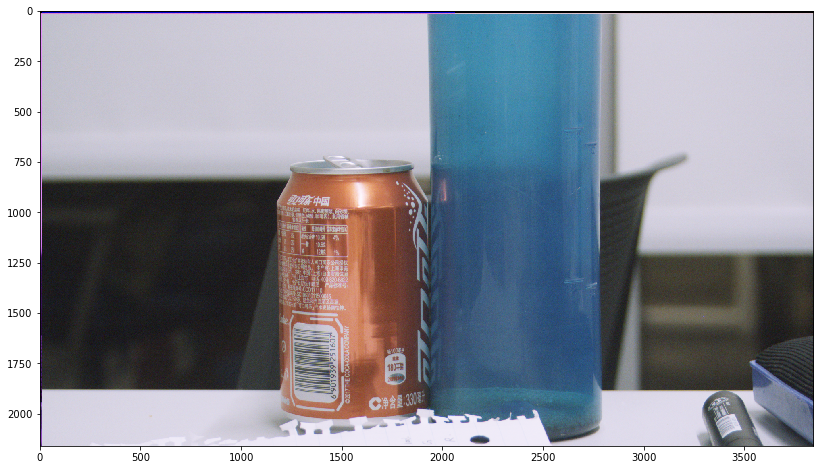

In [10]:
d = trans.rotate(c, 180)
d = adjustColor(d, 0.9, 1.4, 0.70, 1.2, 3)
plt.imshow(d)

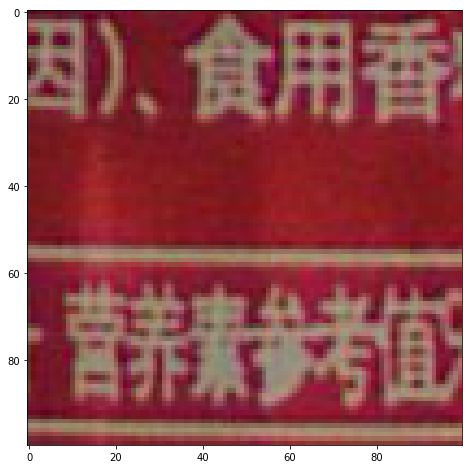

In [11]:
# Task 5
plt.imshow(a[1000:1100, 1400:1500])

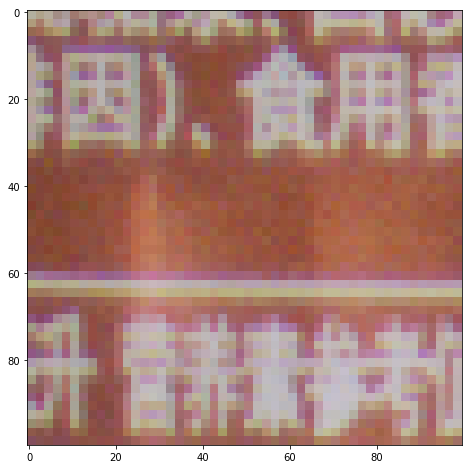

In [12]:
plt.imshow(d[1000:1100, 1400:1500])

It's obvious that the jpg image directly generated by the camera has higher resolution than the the one generated by our demosaic function. In essence, our image is upsampled from a 1080p image in the demosaic function.